# COMP90051 Workshop 4
## Logistic regression

***

In this worksheet, we'll implement logistic regression from scratch using the iteratively reweighted least-squares (IRLS) algorithm presented in lectures. 
In doing so, we'll see how logistic regression can be solved by iteratively performing weighted linear regression.
Finally, we'll compare our IRLS implementation with gradient descent.

Firstly, we'll import the relevant libraries (`numpy`, `matplotlib`, etc.).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 108
RND_SEED = 0

## 1. Binary classification data

Let's begin by generating some binary classification data.
To make it easy for us to visualise the results, we'll stick to a two-dimensional feature space.

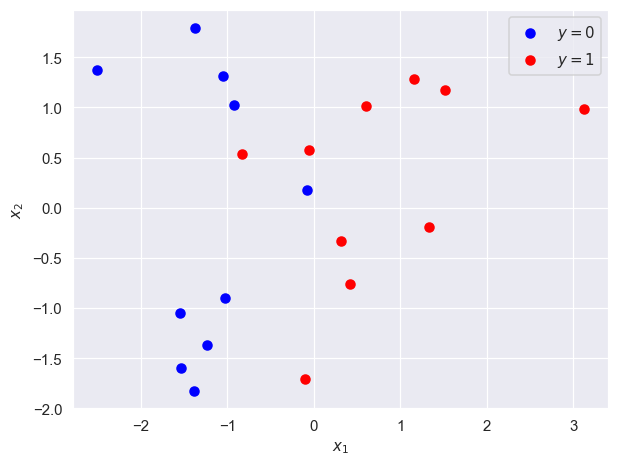

In [3]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 20, n_features = 2, n_informative=2, n_redundant=0, random_state=RND_SEED)
X_b = np.column_stack((np.ones_like(y), X))

plt.scatter(X[y==0,0], X[y==0,1], color='b', label="$y = 0$")
plt.scatter(X[y==1,0], X[y==1,1], color='r', label="$y = 1$")
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

***
**Question:** What do you notice about the data? It is possible for logistic regression to achieve perfect accuracy on this data?
***

No, it can't be completely seperated because of 2 points.

## 2. Weighted linear regression

Before we can implement the IRLS algorithm for logistic regression, we'll need a function that can solve _weighted_ linear regression problems. 
This is a minor extension of the material we covered in last week's worksheet.
Whereas last week, each sample contributed equally to the empirical risk, we now allow the samples to contribute with different weights.
Specifically, the empirical risk becomes:

$$
\hat{R}(\mathbf{w}) = \frac{1}{n} \sum_{i = 1}^{n} m_i (y_i - \mathbf{x}_i^\top \mathbf{w})^2
$$

where $m_i > 0$ is the weight of sample $i$. We assume the feature vectors $\mathbf{x}_i$ have been prepended with "1" entries to incorporate a bias term.

_\[Aside: weighted linear regression can be used in applications where each sample has a different variance $\sigma_i^2$ (e.g. measurement error). The best linear unbiased estimator is obtained by setting $m_i = \frac{1}{\sigma_i^2}$ assuming the variances are known.\]_

Weighted linear regression can also be solved analytically, by generalising the normal equation as follows:

$$
\mathbf{w}^\star = (\mathbf{X}^\top \mathbf{M} \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{M} \mathbf{y},
$$

where $\mathbf{X} = \begin{pmatrix} \mathbf{x}_1^\top \\ \vdots \\ \mathbf{x}_n^\top \end{pmatrix}$, $\mathbf{y} = \begin{pmatrix} y_1 \\ \vdots \\ y_n \end{pmatrix}$ and $\mathbf{M} = \operatorname{diag}(m_1, \ldots, m_n)$.

Below we define a function `fit_linear` that fits a weighted linear model given training data $\mathbf{X}$, $\mathbf{y}$ and sample weights $\mathbf{m} = [m_1, \ldots, m_n]^\top$.

In [4]:
def fit_linear(X, y, sample_weight = None):
    """Fits a linear regression model according to the given training data
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
        
    y : array of shape (n_samples,)
        Response relative to X
    
    sample_weight : numpy.ndarray of shape (n_samples,) default=None
        Weights that are assigned to individual samples.
        If not provided, then each sample is given unit weight.
    
    Returns
    -------
    weights : array of shape (n_features,)
    """
    if sample_weight is not None:
        sqrt_sample_weight = np.sqrt(sample_weight)
        X = X * sqrt_sample_weight[:, np.newaxis]
        y = y * sqrt_sample_weight
    weights, _, _, _ = np.linalg.lstsq(X.T @ X, X.T @ y, rcond=None)
    return weights

## 3. Logistic regression via IRLS

We're now ready to start implementing the IRLS algorithm for logistic regression step-by-step.

Recall that logistic regression assumes a linear relationship between the features $\mathbf{x}$ and the log-odds of the event $Y = 1$:

$$
\log \frac{p(y = 1|\mathbf{x})}{1 - p(y = 1|\mathbf{x})} = \mathbf{x}^\top \mathbf{w}.
$$

From a decision-theoretic point of view, we choose the weights vector $\mathbf{w}$ to minimise the empirical risk under the log-loss (a.k.a. cross-entropy loss and logistic loss):

$$
\hat{R}(\mathbf{w}) = - \frac{1}{n} \sum_{i = 1}^{n} \ell_\mathrm{log}(y_i, \mu_i(\mathbf{w})),
$$

where $\ell_\mathrm{log}(y, \mu) = y \log \mu + (1 - y) \log (1 - \mu)$ and  $\mu_i(\mathbf{w}) := \frac{1}{1 + \exp( - \mathbf{x}_i^\top \mathbf{w})}$.

We'll need to evaluate $\hat{R}(\mathbf{w})$ later on to generate convergence plots, so we define a function for this below.

In [5]:
from sklearn.metrics import log_loss

def risk(X, y, w):
    """Evaluate the empirical risk under the cross-entropy (logistic) loss
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
        
    y : array of shape (n_samples,)
        Response relative to X. Binary classes must be encoded as 0 and 1.
    
    w : array of shape (n_features,)
        Weight vector.
    
    Returns
    -------
    risk : float
    """
    mu = expit(X @ w)
    return log_loss(y, mu)

We'll also need to be able to compute the _gradient_ of the empirical risk $\nabla_{\mathbf{w}} \hat{R}(\mathbf{w}')$ in order to:

* decide when we can stop the IRLS algorithm (we're close to optimality when $\|\nabla_{\mathbf{w}} \hat{R}(\mathbf{w}')\|_\infty \approx 0$)
* implement gradient descent (later) as an alternative to IRLS

It's straightforward to show (using vector calculus) that:

$$
\nabla_{\mathbf{w}} \hat{R}(\mathbf{w}) = \frac{1}{n} \sum_{i = 1}^{n} (\mu_i(\mathbf{w}) - y_i)\mathbf{x}_i = \frac{1}{n} \mathbf{X}^\top (\boldsymbol{\mu} - \mathbf{y}),
$$

where $\boldsymbol{\mu} = \begin{pmatrix} \mu_1(\mathbf{w}) \\ \vdots \\ \mu_n(\mathbf{w}) \end{pmatrix}$.

***
**Exercise:** Complete the `grad_risk` function below, which computes $\nabla_{\mathbf{w}} \hat{R}(\mathbf{w})$ for a given weight vector $\mathbf{w}$ and training data $\mathbf{X}$ and $\mathbf{y}$.
***

In [9]:
def grad_risk(X, y, w):
    """Evaluate the gradient of the empirical risk
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
        
    y : array of shape (n_samples,)
        Response relative to X. Binary classes must be encoded as 0 and 1.
    
    w : array of shape (n_features,)
        Weight vector.
    
    Returns
    -------
    grad_w : array of shape (n_features,)
    """
    grad_w = (X.T @ (expit(X @ w) - y))/ X.shape[0] # fill in
    return grad_w

# Test case
if RND_SEED == 0:
    test_grad_risk_actual = grad_risk(X_b, y, np.ones(3))
    test_grad_risk_desired = np.array([0.11641865, -0.25260051, 0.20606407])
    np.testing.assert_allclose(test_grad_risk_actual, test_grad_risk_desired)

In lectures, we saw that the IRLS algorithm solves logistic regression by iteratively solving a series of weighted linear regression problems.

At iteration $t$, the weights vector $\mathbf{w}_t$ is updated by solving the normal equation:

$$
\mathbf{w}_{t + 1} = (\mathbf{X}^\top \mathbf{M}_t \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{M}_t \mathbf{b}_t,
$$

where 
* $\mathbf{b}_t = \mathbf{X} \mathbf{w}_t + \mathbf{M}_t^{-1}(\mathbf{y} - \boldsymbol{\mu}_t)$ is the linearised response (analogue of $\mathbf{y}$),
* $\mathbf{M}_t = \operatorname{diag}(\boldsymbol{\mu}_t (1 - \boldsymbol{\mu}_t))$ are the sample weights, and
* $\boldsymbol{\mu}_t = [\mu_{1}(\mathbf{w}_t), \ldots, \mu_{n}(\mathbf{w}_t)]^\top$.

***
**Exercise:** Complete the `update_weight_irls` function below, which performs a single IRLS weight update.

_Hint: you should use the previously-defined `fit_linear` function to solve the normal equation._
***

In [12]:
def update_weight_irls(X, y, w):
    """Performs a weight update using the IRLS algorithm
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
    
    y : array of shape (n_samples,)
        Response relative to X. Binary classes must be encoded as 0 and 1.
    
    w : array of shape (n_features,)
        Current estimate of the weight vector.
    
    Returns
    -------
    w : array of shape (n_features,)
        Updated estimate of the weights vector.
    """
    # Compute the sample weights and linearised response
    # fill in
    mu = expit(X @ w)
    M = mu * (1-mu)
    b = (X @ w) + (y - mu) / M
    
    # Fit a weighted linear regression model
    w = fit_linear(X, b, M) # fill in
    
    return w

# Test case
if RND_SEED == 0:
    test_update_weight_irls_actual = update_weight_irls(X_b, y, np.ones(3))
    test_update_weight_irls_desired = np.array([0.88475769, 2.08819846, 0.04110822])
    np.testing.assert_allclose(test_update_weight_irls_actual, test_update_weight_irls_desired)

Now that we've implemented `grad_risk` and `update_weight_irls`, we're very close to being able to run IRLS.
We just need to write some code to:

* initialise the weight vector, and
* iterate until the stopping criterion $\| \nabla_\mathbf{w} \hat{R}(\mathbf{w}_t) \|_\infty \leq \mathtt{tol}$ is satisfied (or a max number of iterations is completed).

We do this in the `fit_logistic` function below. 
Note that we treat the `update_weight` function as a parameter, which defaults to IRLS. 
This will allow us to reuse `fit_logistic` for gradient descent later on.

In [13]:
def fit_logistic(X, y, w_init=None, max_iter = 100, tol = 1e-4, 
                 update_weight = update_weight_irls, **kwargs):
    """Fits a binary logistic regression model according to the given training 
    data
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
        
    y : array of shape (n_samples,)
        Response relative to `X`. Binary classes must be encoded as 0 and 1.
    
    w_init : array of shape (n_features,) default=None
        Initial guess for the weights vector. Defaults to a vector of
        zeroes.
    
    max_iter : int, default=100
        Maximum number of iterations
    
    tol : float, default=1e-4
        Stop when the inf-norm of the gradient falls below this value.
    
    update_weight : callable, default=update_weight_irls
        Callable that performs a weight update. Must have signature 
        (X, y, w, **kwargs). Defaults to IRLS.
    
    **kwargs : 
        Keyword arguments passed to `update_weight`.
    
    Returns
    -------
    w_history : list of arrays of shape (n_features,)
        History of weight vectors
    """
    if w_init is None:
        # Default weight initialisation
        w_init = np.zeros(X.shape[1], dtype=float)
        
    # Store history of weights
    w_history = [w_init]
    w = w_init
    
    for t in range(max_iter):
        w = update_weight(X, y, w, **kwargs)
        w_history.append(w)
        
        # Check stopping criterion
        grad_inf = np.linalg.norm(grad_risk(X, y, w), ord=np.inf)
        if grad_inf <= tol:
            break
    
    print("Stopping after {} iterations".format(t))
    print("Inf-norm of grad is {:.4g}".format(grad_inf))
    
    return w_history

Let's run the algorithm on the 2D classification data we generated in Section 1 and visualise the result. Does the result look reasonable?

Stopping after 6 iterations
Inf-norm of grad is 3.507e-12


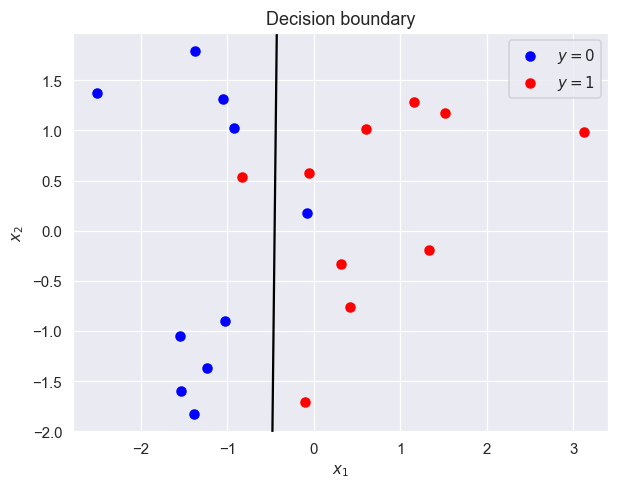

In [14]:
w_history_irls = fit_logistic(X_b, y, tol=1e-9)

def plot_decision_boundary(X, y, w):
    """Plots the decision boundary of a logistic regression classifier defined 
    by weights `w`
    """
    fig, ax = plt.subplots()
    ax.scatter(X_b[y==0,1], X_b[y==0,2], color='b', label="$y = 0$")
    ax.scatter(X_b[y==1,1], X_b[y==1,2], color='r', label="$y = 1$")
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot(list(xlim), [-w[0]/w[2] - w[1]/w[2] * x for x in xlim], ls = "-", color="k")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title("Decision boundary")
    ax.legend()
    plt.show()

plot_decision_boundary(X_b, y, w_history_irls[-1])

We can also check the validity of our implementation by comparing with scikit-learn's implementation. Note that the scikit-learn implementation incorporates $L_2$ regularisation by default, so we need to switch it off by setting `penalty = 'none'`.

In [15]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='none')
clf.fit(X, y)
w_sklearn = np.r_[clf.intercept_, clf.coef_.squeeze()]
print("Weights according to IRLS: {}".format(w_history_irls[-1]))
print("Weights according to scikit-learn: {}".format(w_sklearn))

Weights according to IRLS: [ 1.64777586  3.63949093 -0.04606749]
Weights according to scikit-learn: [ 1.64777385  3.63947254 -0.04607371]


Let's take a look at the path taken by the IRLS algorithm to reach the optimal solution.
We plot the weight vectors at each iteration $\mathbf{w}_0, \mathbf{w}_1, \ldots$ on top of contours of the empirical risk $\hat{R}(\mathbf{w})$. 
The darker the shade, the lower the empirical risk.

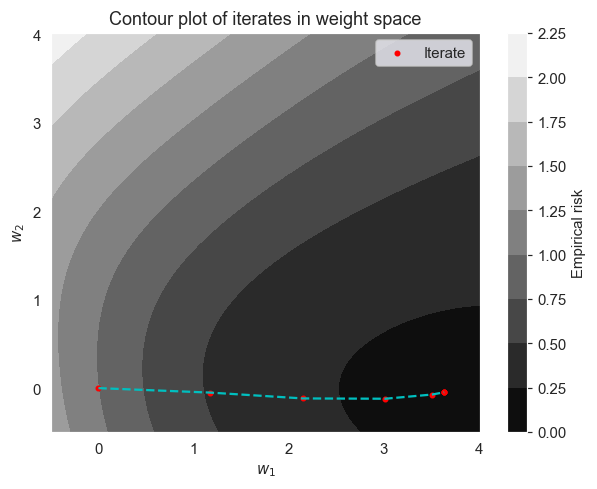

In [16]:
def plot_iterates(X, y, w_history):
    """Plots the path of iterates in weight space (excluding the bias)"""
    w_history = np.array(w_history)
    
    # Compute axes limits
    w12_max = w_history[:,1:].max()
    w12_min = w_history[:,1:].min()
    w12_ran = w12_max - w12_min
    border = 0.1
    
    # Compute objective on grid
    w12 = np.linspace(w12_min - border * w12_ran, w12_max + border * w12_ran, num=100)
    w1v, w2v = np.meshgrid(w12, w12)
    w12v = np.c_[w1v.ravel(), w2v.ravel()]
    z = np.array([risk(X_b, y, np.r_[w_history[-1][0], w12]) for w12 in w12v])
    z = z.reshape(w1v.shape)

    plt.contourf(w1v, w2v, z, cmap='gist_gray')
    plt.colorbar(label='Empirical risk')
    plt.plot(w_history[:,1], w_history[:,2], c='c', ls='--')
    plt.scatter(w_history[:,1], w_history[:,2], c='r', marker='.', label='Iterate')
    plt.xlabel('$w_1$')
    plt.ylabel('$w_2$')
    plt.legend()
    plt.title('Contour plot of iterates in weight space')
    plt.show()

plot_iterates(X_b, y, w_history_irls)

## 4. Logistic regression via gradient descent

Finally, let's compare the IRLS algorithm with gradient descent. 
To do this, we can reuse the `fit_logistic` function defined earlier. 
We just need to replace `update_weight_irls` with an analagous function for gradient descent.

Recall that the weight update for gradient descent at iteration $t$ is given by:

$$
\mathbf{w}_t = \mathbf{w}_{t - 1} - \eta \nabla_\mathbf{w} \hat{R}(\mathbf{w}_{t - 1})
$$

where $\eta > 0$ is a learning rate parameter.
***
**Exercise:** Complete the `update_weight_gd` function below which implements the weight update for gradient descent.
***

In [17]:
def update_weight_gd(X, y, w, **kwargs):
    """Performs a gradient descent weight update
    
    Parameters
    ----------
    X : array of shape (n_samples, n_features)
        Feature matrix. The matrix must contain a constant column to 
        incorporate a non-zero bias.
    
    y : array of shape (n_samples,)
        Response relative to X. Binary classes must be encoded as 0 and 1.
    
    w : array of shape (n_features,)
        Current estimate of the weight vector.
    
    **kwargs : 
        Keyword arguments.
        
    Returns
    -------
    w : array of shape (n_features,)
        Updated estimate of the weights vector.
    """
    # Get learning rate from kwargs, defaulting to 1.0 if None
    eta = kwargs.get("eta", 1)
    return w - eta * grad_risk(X, y, w) # fill in

Let's run our gradient descent implementation on the same classification data from before. 
What do you notice about the path taken by the gradient descent algorithm? 
How does it compare with IRLS?

In [ ]:
w_history_gd = fit_logistic(X_b, y, update_weight=update_weight_gd, max_iter=1000, eta = 5, tol=1e-9)
plot_decision_boundary(X_b, y, w_history_gd[-1])
plot_iterates(X_b, y, w_history_gd)

***
## Bonus: Linearly separable case (optional)


**Exercise:** What happens when you re-run the notebook with `RND_SEED = 90051`?